
# Sydney Incident Duration – Data Cleaning for `sydney_traffic_incidents_clean.csv`

This notebook takes the raw `merged.csv` dataset obtained from https://github.com/Future-Mobility-Lab/SydneyIncidents/tree/main and performs EDA and preprocessing to produce a clean file that is ready to be used by our models.

We encountered several problems with the dataset, such as:

- At least one of the column names had trailing whitespace, which caused issues when trying to access that column in code. We will strip this whitespace.
- Some rows had missing values, but this was a small percentage of the total so those were simply dropped.
- The "duration" column had some extreme outliers, such as durations equal to zero. Almost all observations had duration between 0 and 500 minutes, so these outliers are dropped.
- There are several columns that contain duplicate or near duplicate data. The reduntant columns are dropped.
- We are primarily performing classification between "long" and "short" incidents, demarked as being above or below 30 minutes. However, there is no classification field for this, so an additional column, "duration_classification", was derived from the continuous "duration" values, with 0 = "short" and 1 = "long".
- The result is in saved to `sydney_traffic_incidents_clean.csv` for easy import into notebooks performing model training and analaysis.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

raw_path = "merged.csv"
df_raw = pd.read_csv(raw_path)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (85611, 88)


,Main_Category,Longitude,Latitude,Day,duration,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Advice_B,Closure_Type,Direction,Main_Street,Affected_Lanes,Actual_Number_of_Lanes,Suburb,Traffic_Volume,SA2_CODE21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,AREASQKM21,0_ZID,1_Area,2_ML,3_TRL,4_PRL,5_SRL,6_TrRL,7_RRL,8_LsRL,9_URL,10_ToRL,11_EoR,12_NoN,13_NDEs,14_NNC2L,15_NNC3L,16_NNC4L,17_AND,18_NE,19_MCI,20_CoI,21 NBS,22_CA,23_EA,24_HA,25_IA,26_OA,27_PA,28_PrA,29_RA,30_TA,31_WbA,32_EoLU,33_TP,34_PD0MV,35_PD1MV,36_PD2MV,37_PD3MV,38_PD≥4MV,39_PUE,40_AMI,41_NPTtWbyPT,42_NPTtWbyTx,43_NPTtWbyCD,44_NPTtWbyCP,45_NPTtWbyO,46_NPWfH,47_PWCJH,48_PBCJH,49_ANP_FH,RMS,Motorway Crew,Mechanic,Emergency service(s),Tow Truck,Motorway crew,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD
0,1,151.058,-33.9431,5,39.319950,1,2,0,10,0,0,3,1680,99,99,841,3,119021366,11902,11,119,4,5.2458,119021366,5.2458,7.488104,3.038780,2.236683,6.602571,2.551265,42.103090,0.0,0.115587,64.136080,0.504771,325,40,7,260,17,2.790769,491,0.258915,0.001351,210,0.0938,0.1211,0.0000,0.7056,0.0,0.5171,0.0,3.8082,0.0000,0.0,0.386385,21537,11.297837,37.886855,30.565724,12.296173,7.953411,12.109393,831,342,16,2806,276,260,1520,67.634460,32.365540,3.713468,0,0,0,0,0,0,1,0,0,0,0,2,8,19,15.781064
1,0,151.159,-33.8096,6,12.029000,1,9,0,10,134,2,8,1343,1,2,535,3,121011399,12101,13,121,6,5.5372,121011399,5.5372,8.365015,2.097842,7.903368,4.617769,0.232704,40.351141,0.0,0.739679,64.307518,0.515889,269,59,6,176,28,2.643123,383,0.215760,0.001839,210,0.0080,0.1223,0.0238,0.0000,0.0,1.3725,0.0,4.0106,0.0000,0.0,0.302463,21270,10.253288,52.715538,29.067219,5.723332,2.240623,7.776211,1643,651,6,2652,227,514,6070,88.007396,11.992604,3.023239,0,1,0,0,0,0,0,0,0,0,1,1,8,0,8.323913
2,1,150.875,-33.7344,6,16.956667,1,9,0,26,134,2,8,2845,1,1,810,3,116011304,11601,3,116,1,7.3828,116011304,7.3828,9.051683,0.000000,12.307502,5.297219,9.525819,56.104489,0.0,0.128916,92.415628,0.523895,468,112,2,307,47,2.617521,631,0.176155,0.001177,234,0.0000,0.2768,0.0000,0.3180,0.0,0.9027,0.0,5.6929,0.1924,0.0,0.352217,20570,8.724832,41.000610,34.716290,10.600976,4.957291,9.688867,1030,532,18,3686,323,256,2398,67.554766,32.445234,3.341706,0,1,0,0,0,0,1,0,0,0,0,1,8,1,34.354983
3,1,150.973,-33.8172,6,42.804117,5,2,0,10,0,0,8,1537,1,1,901,2,125041589,12504,31,125,10,3.9355,125041589,3.9355,9.698544,8.941532,0.016410,1.416884,5.140331,32.486126,0.0,0.512046,58.211873,0.547443,266,39,7,188,31,2.804511,402,0.259962,0.001650,174,0.1010,0.1006,0.0236,0.0000,0.0,0.2426,0.0,3.1727,0.2950,0.0,0.329226,21564,13.219616,56.830135,22.857143,4.804549,2.288557,9.956409,1302,902,11,2707,291,311,4379,78.956666,21.043334,3.248887,0,0,0,0,0,0,1,1,0,0,0,1,8,1,22.500677
4,1,150.981,-33.7919,6,40.840000,3,4,0,10,134,0,7,2059,99,99,742,3,125041493,12504,31,125,10,7.4795,125041493,7.4795,0.000000,9.092391,0.000000,7.092430,13.338771,51.982067,0.0,4.266734,85.772393,0.515169,454,105,3,322,23,2.585903,598,0.160576,0.001272,194,0.4036,0.1788,0.0000,0.0000,0.0,0.8217,0.0,6.0754,0.0000,0.0,0.285901,22840,8.134605,39.745628,35.466349,10.996290,5.657128,9.071804,1170,589,18,3487,314,261,3798,77.384802,22.615198,3.295874,0,0,0,0,1,0,0,0,0,0,0,3,8,1,22.753003



I noticed at least one column has trailing whitespace in its name, which causes issues when pulling column data in code. 

The columns where identified, and the issue was fixed for the clean .csv:


In [2]:

# identify columns with extraneous whitespace
cols_with_ws = [c for c in df_raw.columns if c != c.strip()]
print("Columns with whitespace in their names:", cols_with_ws)

# strip whitespace from all column names
df_raw.columns = df_raw.columns.str.strip()

# verify the fix
print([c for c in df_raw.columns if c != c.strip()])

# check the head again to make sure it looks right
df_raw.head()

Columns with whitespace in their names: ['Actual_Number_of_Lanes ']
[]


,Main_Category,Longitude,Latitude,Day,duration,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Advice_B,Closure_Type,Direction,Main_Street,Affected_Lanes,Actual_Number_of_Lanes,Suburb,Traffic_Volume,SA2_CODE21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,AREASQKM21,0_ZID,1_Area,2_ML,3_TRL,4_PRL,5_SRL,6_TrRL,7_RRL,8_LsRL,9_URL,10_ToRL,11_EoR,12_NoN,13_NDEs,14_NNC2L,15_NNC3L,16_NNC4L,17_AND,18_NE,19_MCI,20_CoI,21 NBS,22_CA,23_EA,24_HA,25_IA,26_OA,27_PA,28_PrA,29_RA,30_TA,31_WbA,32_EoLU,33_TP,34_PD0MV,35_PD1MV,36_PD2MV,37_PD3MV,38_PD≥4MV,39_PUE,40_AMI,41_NPTtWbyPT,42_NPTtWbyTx,43_NPTtWbyCD,44_NPTtWbyCP,45_NPTtWbyO,46_NPWfH,47_PWCJH,48_PBCJH,49_ANP_FH,RMS,Motorway Crew,Mechanic,Emergency service(s),Tow Truck,Motorway crew,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD
0,1,151.058,-33.9431,5,39.319950,1,2,0,10,0,0,3,1680,99,99,841,3,119021366,11902,11,119,4,5.2458,119021366,5.2458,7.488104,3.038780,2.236683,6.602571,2.551265,42.103090,0.0,0.115587,64.136080,0.504771,325,40,7,260,17,2.790769,491,0.258915,0.001351,210,0.0938,0.1211,0.0000,0.7056,0.0,0.5171,0.0,3.8082,0.0000,0.0,0.386385,21537,11.297837,37.886855,30.565724,12.296173,7.953411,12.109393,831,342,16,2806,276,260,1520,67.634460,32.365540,3.713468,0,0,0,0,0,0,1,0,0,0,0,2,8,19,15.781064
1,0,151.159,-33.8096,6,12.029000,1,9,0,10,134,2,8,1343,1,2,535,3,121011399,12101,13,121,6,5.5372,121011399,5.5372,8.365015,2.097842,7.903368,4.617769,0.232704,40.351141,0.0,0.739679,64.307518,0.515889,269,59,6,176,28,2.643123,383,0.215760,0.001839,210,0.0080,0.1223,0.0238,0.0000,0.0,1.3725,0.0,4.0106,0.0000,0.0,0.302463,21270,10.253288,52.715538,29.067219,5.723332,2.240623,7.776211,1643,651,6,2652,227,514,6070,88.007396,11.992604,3.023239,0,1,0,0,0,0,0,0,0,0,1,1,8,0,8.323913
2,1,150.875,-33.7344,6,16.956667,1,9,0,26,134,2,8,2845,1,1,810,3,116011304,11601,3,116,1,7.3828,116011304,7.3828,9.051683,0.000000,12.307502,5.297219,9.525819,56.104489,0.0,0.128916,92.415628,0.523895,468,112,2,307,47,2.617521,631,0.176155,0.001177,234,0.0000,0.2768,0.0000,0.3180,0.0,0.9027,0.0,5.6929,0.1924,0.0,0.352217,20570,8.724832,41.000610,34.716290,10.600976,4.957291,9.688867,1030,532,18,3686,323,256,2398,67.554766,32.445234,3.341706,0,1,0,0,0,0,1,0,0,0,0,1,8,1,34.354983
3,1,150.973,-33.8172,6,42.804117,5,2,0,10,0,0,8,1537,1,1,901,2,125041589,12504,31,125,10,3.9355,125041589,3.9355,9.698544,8.941532,0.016410,1.416884,5.140331,32.486126,0.0,0.512046,58.211873,0.547443,266,39,7,188,31,2.804511,402,0.259962,0.001650,174,0.1010,0.1006,0.0236,0.0000,0.0,0.2426,0.0,3.1727,0.2950,0.0,0.329226,21564,13.219616,56.830135,22.857143,4.804549,2.288557,9.956409,1302,902,11,2707,291,311,4379,78.956666,21.043334,3.248887,0,0,0,0,0,0,1,1,0,0,0,1,8,1,22.500677
4,1,150.981,-33.7919,6,40.840000,3,4,0,10,134,0,7,2059,99,99,742,3,125041493,12504,31,125,10,7.4795,125041493,7.4795,0.000000,9.092391,0.000000,7.092430,13.338771,51.982067,0.0,4.266734,85.772393,0.515169,454,105,3,322,23,2.585903,598,0.160576,0.001272,194,0.4036,0.1788,0.0000,0.0000,0.0,0.8217,0.0,6.0754,0.0000,0.0,0.285901,22840,8.134605,39.745628,35.466349,10.996290,5.657128,9.071804,1170,589,18,3487,314,261,3798,77.384802,22.615198,3.295874,0,0,0,0,1,0,0,0,0,0,0,3,8,1,22.753003


Next we inspect the data for any outliers, such as zero duration incidents or extremely long duration incidents. It turns out there are some outliers, but they do not make up a large percentage of our dataset, so those outliers are dropped:


In [3]:

df_raw["duration"].describe()


count     85611.000000
mean         44.863947
std         454.097287
min           0.000000
25%          14.943592
50%          28.719767
75%          51.747558
max      127729.214500
Name: duration, dtype: float64

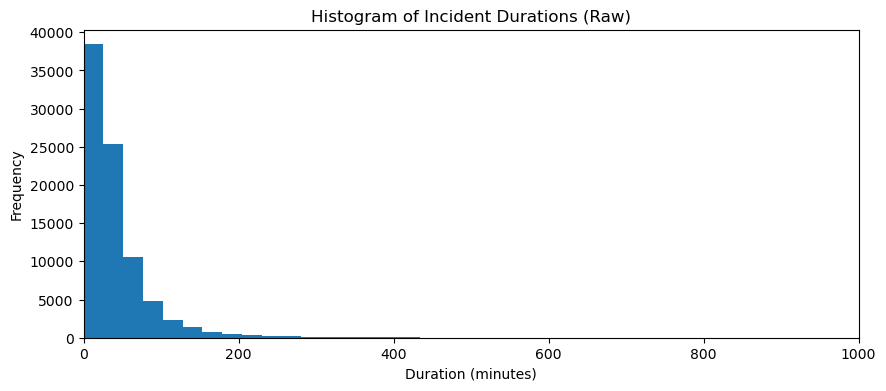

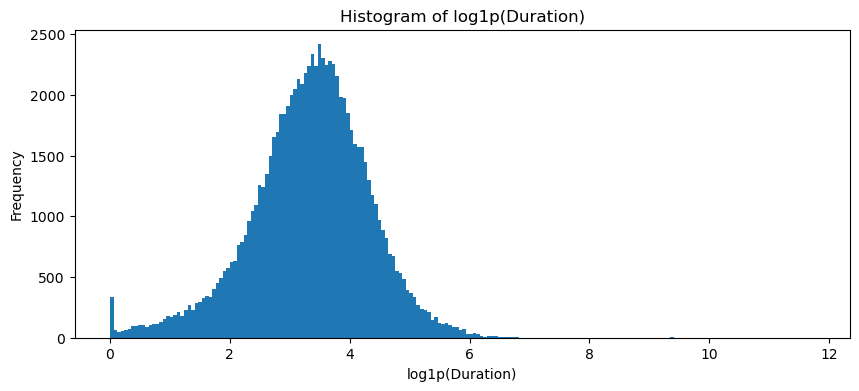

In [4]:

# Histogram of raw durations
plt.figure(figsize=(10, 4))
plt.hist(df_raw["duration"], bins=5000)
plt.title("Histogram of Incident Durations (Raw)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.xlim(0, 1000)  # zoom into the most relevant range
plt.show()

# Histogram of log-transformed durations
plt.figure(figsize=(10, 4))
plt.hist(np.log1p(df_raw["duration"]), bins=200)
plt.title("Histogram of log1p(Duration)")
plt.xlabel("log1p(Duration)")
plt.ylabel("Frequency")
plt.show()



Clearly almost all data points are between (0, 500) minutes in duration. Zero duration incidents seem likely to be a fault of bookkeeping, since any true incident takes longer than zero time, and the longer duration incidents may be mistakes, or simply extreme outliers that will not help with forecasting. We will remove these:


## 4. Identify and filter invalid / extreme durations

In [5]:

# Count clearly invalid and extreme duration values
n_nonpositive = (df_raw["duration"] <= 0).sum()
n_long = (df_raw["duration"] > 500).sum()

print("Durations <= 0:", n_nonpositive)
print("Long outliers > 500 minutes:", n_long)


Durations <= 0: 92
Long outliers > 500 minutes: 88


In [6]:
# the outliers are a very small percentage of the samples, so they can be safely dropped
df = df_raw.copy()
print("Shape before duration filtering:", df.shape)

mask_valid = (df["duration"] > 0) & (df["duration"] <= 500)
df = df[mask_valid].copy()

print("Shape after duration filtering:", df.shape)


Shape before duration filtering: (85611, 88)
Shape after duration filtering: (85431, 88)


In [7]:
# next, inspect the dataset for NaN values
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts[na_counts > 0]


29_RA    2807
dtype: int64

In [8]:
# these also make up a small percentage of datapoints and can be safely dropped
print("Before dropping NaNs:", df.shape)
df = df.dropna(axis=0).copy()
print("After dropping NaNs:", df.shape)


Before dropping NaNs: (85431, 88)
After dropping NaNs: (82624, 88)


Several columns appear to have duplicate or near duplicate data. This can cause issues in our models, so we will drop the duplications.

First, examine the correlations to see if the data is dependant:

In [9]:

numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

high_correllation = []

for i, c1 in enumerate(corr.columns):
    for j in range(i + 1, len(corr.columns)):
        c2 = corr.columns[j]
        val = corr.iloc[i, j]
        if abs(val) > 0.99:
            high_correllation.append((c1, c2, val))

print("Highly correlated columns > 0.99:")
for c1, c2, v in high_correllation:
    print(f"  {c1:15s} {c2:15s}  corr={v:.10f}")


Highly correlated columns > 0.99:
  SA2_CODE21      SA3_CODE21       corr=0.9999999994
  SA2_CODE21      SA4_CODE21       corr=0.9999956414
  SA2_CODE21      SA4_NAME21       corr=0.9999956414
  SA2_CODE21      0_ZID            corr=1.0000000000
  SA3_CODE21      SA4_CODE21       corr=0.9999956448
  SA3_CODE21      SA4_NAME21       corr=0.9999956448
  SA3_CODE21      0_ZID            corr=0.9999999994
  SA4_CODE21      SA4_NAME21       corr=1.0000000000
  SA4_CODE21      0_ZID            corr=0.9999956414
  SA4_NAME21      0_ZID            corr=0.9999956414
  AREASQKM21      1_Area           corr=1.0000000000


Examining this, we see that SA2_CODE21 contains almost the exact same information as:
- SA3_CODE21
- SA4_CODE21
- SA4_NAME21
- 0_ZID
  
and AREASQKM21 contains the same information as 1_Area. I will keep the first two columns and drop the rest:

In [10]:

# Columns identified as duplicate / redundant identifiers
redundant_cols = [
    "SA3_CODE21",
    "SA4_CODE21",
    "SA4_NAME21",
    "0_ZID",
    "1_Area",
]

print("Shape before dropping:", df.shape)

cols_to_drop = [c for c in redundant_cols if c in df.columns]
print("Dropping columns:", cols_to_drop)

df_clean = df.drop(columns=cols_to_drop)
print("Shape after dropping:", df_clean.shape)


Shape before dropping: (82624, 88)
Dropping columns: ['SA3_CODE21', 'SA4_CODE21', 'SA4_NAME21', '0_ZID', '1_Area']
Shape after dropping: (82624, 83)


Now we need to add a "duration_class" column to simplify our classification tasks.

Currently, the dataset contains a "duration" column containing continuous values, measuered in minutes. For classification, however, we want to split it into two categories:
- duration_class = 1 if duration > 30
- duration_class = 0 if duration <= 30

In [11]:
df_clean["duration_class"] = (df_clean["duration"] > 30).astype(int)

df_clean[["duration", "duration_class"]].head()

,duration,duration_class
0,39.319950,1
1,12.029000,0
2,16.956667,0
3,42.804117,1
4,40.840000,1


Now let's see what the balance of the "long" and "short" duration classes are in our dataset:

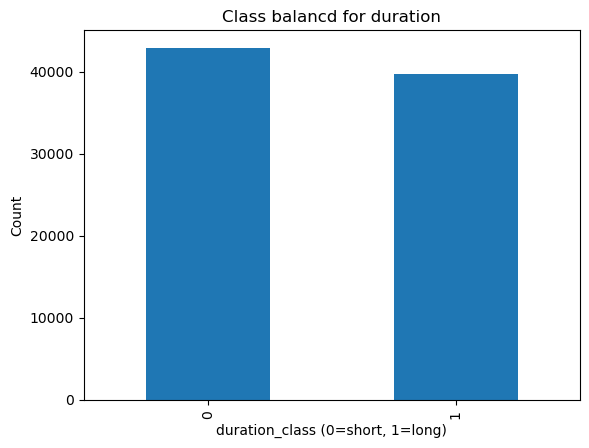

In [12]:
df_clean["duration_class"].value_counts().plot(kind="bar")
plt.title("Class balancd for duration")
plt.xlabel("duration_class (0=short, 1=long)")
plt.ylabel("Count")
plt.show()

Looks like this is a nicely balanced dataset! Finally, I will save this output to a new .csv to make it easy to import the preprocessed dataset into our models:

In [13]:

output_path = "sydney_traffic_incidents_clean.csv"
df_clean.to_csv(output_path, index=False)
output_path


'sydney_traffic_incidents_clean.csv'